In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import numpy as np
from operator import itemgetter
import os
import pickle as pkl
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from hybrid.hmm.multiple import FullGaussianHMM

The default DNN set-up should take ~40 seconds/epoch on a GPU (and ~350 secconds/epoch on a CPU).

Performance (WER) on test set:   

Baseline performance of the GMM-HMM model   
24.55%

Performance of the DNN-HMM model with normalized emission probabilities   
20.45%

Performance of the DNN-HMM model with unnormalized emission probabilities   
18.18%

## Training a multiple digit GMM-HMM model
NOTE: You are not expected to run/tune this part as the trained FullGaussianHMM model file is provided. The provided model is designed to have 15 states for each digit and 3 additional states for start, pause, and end. Feel free to look through hybrid/hmm/multiple.py to see how we can string single-digit HMMs to obtain the one that can model multiple-digit sequences.

In [3]:
# """
# Multiple Digit HMM: training two-digit sequences
# """
# data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)
# full_model = FullGaussianHMM(data_multiple_digit["Xtrain"], "hybrid/hmm/models/single_digit_model.pkl")

# n_iter = 15

# print("Training HMM")
# for i in range(n_iter):
#     print("starting iteration {}...".format(i + 1))
#     full_model.train(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"])
        
# print("Testing HMM")
# test_wer = full_model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"])
# print("{:.2f}% WER".format(test_wer * 100.))

# with open("hybrid/hmm/models/multiple_digit_model.pkl", "wb") as f:
#     pkl.dump(full_model, f)

## Saving the optimal state sequences
Save the optimal state label per framee using the trained GMM-HMM model. Complete the # TODO in force_align function

In [4]:
def force_align(X, Y, hmm_gmm_model):
    """
    Force align using Viterbi to get the hidden state sequence for each (X, Y) pair.
    ------
    input:
    X: list of 2d-arrays of shape (Tx, 13): list of single digit MFCC features
    Y: digit sequence
    hmm_gmm_model: load the trained model
    ------
    Returns a list of utterence-wise hidden state sequences
    """
    start_states, stop_states = hmm_gmm_model.start_states, hmm_gmm_model.stop_states
    begin_sil_id, pause_id, end_sil_id = hmm_gmm_model.begin_sil, hmm_gmm_model.pause, hmm_gmm_model.end_sil
    A_estimate, pi_estimate = hmm_gmm_model.A, hmm_gmm_model.pi
    state_seqs = []
    for ii, (x, y) in enumerate(zip(X, Y)):

        y = np.array([0 if yy == 'o' else int(yy) for yy in y], dtype=np.int32)

        # TODO: edit A_estimate appropriately to enable decoding for the ground-truth labelss
        y1, y2 = y
        stop_y1, stop_y2 = stop_states[y1], stop_states[y2]
        # begin to the start state of y1, preserve some self-transitioning prob for begin
        temp = A_estimate[begin_sil_id, begin_sil_id]
        A_estimate[begin_sil_id] = 0
        A_estimate[begin_sil_id, begin_sil_id] = temp
        A_estimate[begin_sil_id, start_states[y1]] = 1 - temp
        # stop state of y1 to pause, preserve self
        temp = A_estimate[stop_states[y1], stop_states[y1]]
        A_estimate[stop_states[y1]] = 0
        A_estimate[stop_states[y1], stop_states[y1]] = temp
        A_estimate[stop_states[y1], pause_id] = 1 - temp
        # pause to the start state of y2, preserve some self-transitioning prob for pause
        temp = A_estimate[pause_id, pause_id]
        A_estimate[pause_id] = 0
        A_estimate[pause_id, pause_id] = temp
        A_estimate[pause_id, start_states[y2]] = 1 - temp
        # stop state of y2 to end_sil, preserve self
        temp = A_estimate[stop_states[y2], stop_states[y2]]
        A_estimate[stop_states[y2]] = 0
        A_estimate[stop_states[y2], stop_states[y2]] = temp
        A_estimate[stop_states[y2], end_sil_id] = 1 - temp
        
        log_pi = np.log(pi_estimate)
        log_A = np.log(A_estimate)
        log_B = hmm_gmm_model.get_emissions(x)

        q, log_prob = hmm_gmm_model.viterbi(log_pi, log_A, log_B) 
        state_seqs.append(q)

    return state_seqs

In [5]:
if not os.path.exists('hybrid/data/state_seq/state_seq.npz'):
    data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)
    with open("hybrid/hmm/models/multiple_digit_model.pkl", "rb") as f:
        hmm_gmm_model = pkl.load(f)

    state_seq_train = force_align(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"], hmm_gmm_model)
    state_seq_dev = force_align(data_multiple_digit["Xdev"], data_multiple_digit["Ydev"], hmm_gmm_model)
    state_seq_test = force_align(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"], hmm_gmm_model)
    seqDict = {'Ytrain': state_seq_train, 'Ydev': state_seq_dev, 'Ytest': state_seq_test, 'total_states': hmm_gmm_model.total}
    np.savez_compressed('hybrid/data/state_seq/state_seq.npz', **seqDict)

## Training a DNN frame classifier

In [6]:
from hybrid.dnn.loader import DataLoader

In [7]:
# global config, not yet overridden
with open("hybrid/dnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]
out_cfg = config["output"]

In [8]:
print("Preparing data...\n")
data_mfccs = np.load(data_cfg["mfcc"], allow_pickle=True)
state_seq = np.load(data_cfg["state_seq"], allow_pickle=True)

data_ldr = DataLoader(data_cfg)
train_features, train_labels, train_labels_onehot, train_utt_to_frames = data_ldr.prepare_data('train')
dev_features, dev_labels, dev_labels_onehot, dev_utt_to_frames = data_ldr.prepare_data('dev')
test_features, test_labels, test_labels_onehot, test_utt_to_frames = data_ldr.prepare_data('test')

feat_dim = (data_ldr.context_size+1)*data_ldr.mfcc_dim
n_states = data_ldr.n_states

Preparing data...



In [9]:
class FeedForward(nn.Module):

    def __init__(self, feat_dim, n_states, hidden_dim, n_layers, dropout):
        """
        Initialized feed forward neural network model.
        ---
        feat_dim: input feature dimension
        n_states: size of the output
        hidden_dim: dimension of the hidden layers
        n_layers: number of layers
        dropout: dropout probabilty for the dropout layer
        """
        super().__init__()

        self.n_layers = n_layers
        self.fc_input = nn.Linear(feat_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, n_states)
        self.fc_hidden_list = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim)]*n_layers)
        self.nl = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Forward pass for the feedforward network
        """
        x = self.nl(self.fc_input(x))
        for i in range(self.n_layers):
            x = self.nl(self.fc_hidden_list[i](x))
        output = F.leaky_relu(self.fc_output(x))

        return output

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

In [10]:
def train(classifier, optimizer):
    """
    Training the classifier on frame level labels
    """
    classifier.train()
    perm = np.random.permutation(train_features.shape[0])
    train_loss, pred_multi, gt_multi = [], [], []
    n_iter = 0
    start = time.time()
    time_per_iter = [0]*4
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        train_Xs = torch.tensor(train_features[idx], dtype=torch.float32).to(device)
        train_Ys = torch.tensor(train_labels[idx], dtype=torch.long).to(device)
        pred_Ys = classifier(train_Xs)
        loss = loss_function(pred_Ys, train_Ys)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 5.0)
        optimizer.step()
        train_loss.append(loss.cpu().item())
        pred_multi.append(np.argmax(pred_Ys.cpu().data.numpy(), axis=1))
        gt_multi.append(train_Ys.cpu().data.numpy())
    pred_multi, gt_multi = np.concatenate(pred_multi, axis=0), np.concatenate(gt_multi, axis=0)
    accuracy = 100*len(np.where((pred_multi - gt_multi)==0)[0])/len(pred_multi)
    print("Training time elapsed: %.2f seconds" % (time.time() - start))
    return accuracy, np.mean(train_loss)

def test(features, labels, classifier_test=None):
    """
    Training the classifier on frame level labels
    """
    if classifier_test is None:
        classifier_test = torch.load(save_model_fn)
    classifier_test.eval()
    test_loss, pred_multi, gt_multi = [], [], []
    n_iter = 0
    start = time.time()
    for i in range(0, len(features), test_batch_size):
        n_iter += 1
        idx = list(range(i, min(i+test_batch_size, len(features))))
        test_Xs = torch.tensor(features[idx], dtype=torch.float32).to(device)
        test_Ys = torch.tensor(labels[idx], dtype=torch.long).to(device)
        pred_Ys = classifier_test(test_Xs)
        loss = loss_function(pred_Ys, test_Ys)
        test_loss.append(loss.cpu().item())
        pred_multi.append(np.argmax(pred_Ys.cpu().data.numpy(), axis=1))
        gt_multi.append(test_Ys.cpu().data.numpy())

    pred_multi, gt_multi = np.concatenate(pred_multi, axis=0), np.concatenate(gt_multi, axis=0)
    accuracy = 100*len(np.where((pred_multi - gt_multi)==0)[0])/len(pred_multi)
    print("Dev elapsed: %.2f seconds" % (time.time() - start))
    return accuracy

In [11]:
def main_train(classifier, optimizer, curr_config):
    plotting = {'train_loss': [], 'train_accu': [], 'dev_accu': []}
    global global_best_accu
    best_accuracy = 0
    for epoch in range(tot_epoch):
        train_accuracy, loss = train(classifier, optimizer)
        dev_accuracy = test(dev_features, dev_labels, classifier)
        print("Epoch: %d, Training loss: %.2f, Accuracy: %.2f, Dev Accuracy: %.2f" % 
              (epoch, loss, train_accuracy, dev_accuracy))
        
        plotting['train_loss'].append(loss)
        plotting['train_accu'].append(train_accuracy)
        plotting['dev_accu'].append(dev_accuracy)
        
        if dev_accuracy > global_best_accu:
            best_epoch = epoch
            torch.save(classifier, save_model_fn) # global dnn-model.pkl
            global_best_accu = dev_accuracy
        if dev_accuracy > best_accuracy: # save temporarily
            best_epoch = epoch
            torch.save(classifier, os.path.join(out_cfg["save_dir"], curr_config))
            best_accuracy = dev_accuracy
    print('\nBest dev accuracy: %.2f at epoch: %d' % (best_accuracy, best_epoch))
    return plotting

def main_test():
    accuracy = test(test_features, test_labels)
    print('\nAccuracy on test set: %.2sf' % (accuracy))

In [12]:
# more global config
tot_epoch = opt_cfg["max_epochs"]
batch_size = opt_cfg["batch_size"]
test_batch_size = opt_cfg["test_batch_size"]

save_model_fn = os.path.join(out_cfg["save_dir"], "dnn_model.pkl")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.deterministic = True
    
loss_function = nn.CrossEntropyLoss()

In [13]:
# TODO: tune on the dev set
# may want to set up function or chunk of code here to perform tuning
# call train on training set, call test on dev, save/plot/compare results
global_best_accu = 0

In [14]:
# plotting helper
def plot_loss_accu(best, plotting, xlabel='# epochs', xticks=None):
    plt.suptitle(best)
    plt.subplot(1, 2, 1)
    if xticks is None:
        plt.plot(plotting['train_loss'], label='train_loss')
    else:
        plt.plot(xticks, plotting['train_loss'], label='train_loss')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('train_loss')
    plt.subplot(1, 2, 2)
    if xticks is None:
        plt.plot(plotting['dev_accu'], label='dev_accu')
        plt.plot(plotting['train_accu'], label='train_accu')
    else:
        plt.plot(xticks, plotting['dev_accu'], label='dev_accu')
        plt.plot(xticks, plotting['train_accu'], label='train_accu')    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('accuracy')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('figures/' + best + '.png')
    plt.show()

In [15]:
def tune(hyperparams):    
    hidden_dim = hyperparams.get('hidden_dim', model_cfg["hidden_dim"])
    n_layers = hyperparams.get('n_layers', model_cfg["n_layers"])
    dropout = hyperparams.get('dropout', model_cfg["dropout_probability"])
    
    curr_config = 'hid{}+n_layers{}+dropout{}'.format(hidden_dim, n_layers, dropout)
    print('\nTraining DNN with config:', curr_config)
    classifier = FeedForward(feat_dim, n_states, hidden_dim, n_layers, dropout).to(device)
    # classifier.apply(init_weights)
    optimizer = getattr(torch.optim, opt_cfg["type"])(list(classifier.parameters()))

    plotting = main_train(classifier, optimizer, curr_config)
    return curr_config, plotting

### (e) i. Plots of the loss and accuracy vs. epoch on train and dev


Training DNN with config: hid512+n_layers1+dropout0.0
Training time elapsed: 76.90 seconds
Dev elapsed: 2.36 seconds
Epoch: 0, Training loss: 2.07, Accuracy: 43.06, Dev Accuracy: 47.77


/home/ruolinzheng/.local/lib/python3.5/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FeedForward. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training time elapsed: 77.03 seconds
Dev elapsed: 2.37 seconds
Epoch: 1, Training loss: 1.48, Accuracy: 56.79, Dev Accuracy: 48.06
Training time elapsed: 77.68 seconds
Dev elapsed: 2.37 seconds
Epoch: 2, Training loss: 1.30, Accuracy: 61.08, Dev Accuracy: 51.93
Training time elapsed: 77.53 seconds
Dev elapsed: 2.37 seconds
Epoch: 3, Training loss: 1.20, Accuracy: 64.13, Dev Accuracy: 50.95
Training time elapsed: 77.49 seconds
Dev elapsed: 2.37 seconds
Epoch: 4, Training loss: 1.12, Accuracy: 66.30, Dev Accuracy: 50.56
Training time elapsed: 77.69 seconds
Dev elapsed: 2.37 seconds
Epoch: 5, Training loss: 1.06, Accuracy: 68.07, Dev Accuracy: 51.01
Training time elapsed: 77.56 seconds
Dev elapsed: 2.36 seconds
Epoch: 6, Training loss: 1.01, Accuracy: 69.45, Dev Accuracy: 49.93
Training time elapsed: 76.82 seconds
Dev elapsed: 2.36 seconds
Epoch: 7, Training loss: 0.97, Accuracy: 70.60, Dev Accuracy: 49.16
Training time elapsed: 77.46 seconds
Dev elapsed: 2.36 seconds
Epoch: 8, Training l

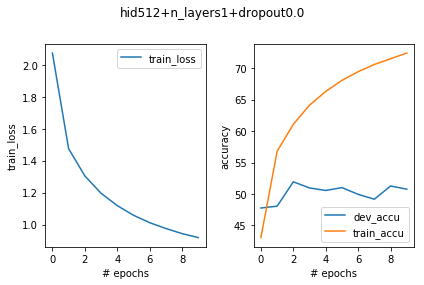

In [16]:
# # default config
# plt_title, plotting = tune({})
# plot_loss_accu(plt_title, plotting)

## (e) ii. For models trained with dropout 0.3, 0.5, 0.8, plot loss and accuracy

In [17]:
def experiment(param_name, param_range):
    data = {'train_loss': [], 'train_accu': [], 'dev_accu': []}
    for param in param_range:
        hp = {param_name: param, 'dropout': 0.5}
        _, plotting = tune(hp)
        # record best dev accuracy
        idx = np.argmax(plotting['dev_accu'])
        for k in data:
            data[k].append(plotting[k][idx])
    #     plot_wer_loss(best, plotting)
    plot_loss_accu(param_name, data, xlabel=param_name, xticks=param_range)


Training DNN with config: hid512+n_layers1+dropout0.3
Training time elapsed: 77.29 seconds
Dev elapsed: 2.37 seconds
Epoch: 0, Training loss: 2.24, Accuracy: 40.89, Dev Accuracy: 43.04
Training time elapsed: 77.04 seconds
Dev elapsed: 2.37 seconds
Epoch: 1, Training loss: 1.53, Accuracy: 55.69, Dev Accuracy: 49.21
Training time elapsed: 77.45 seconds
Dev elapsed: 2.37 seconds
Epoch: 2, Training loss: 1.36, Accuracy: 60.10, Dev Accuracy: 51.46
Training time elapsed: 77.40 seconds
Dev elapsed: 2.37 seconds
Epoch: 3, Training loss: 1.25, Accuracy: 63.04, Dev Accuracy: 50.82
Training time elapsed: 77.33 seconds
Dev elapsed: 2.37 seconds
Epoch: 4, Training loss: 1.17, Accuracy: 65.27, Dev Accuracy: 51.71
Training time elapsed: 77.60 seconds
Dev elapsed: 2.71 seconds
Epoch: 5, Training loss: 1.11, Accuracy: 66.81, Dev Accuracy: 50.57
Training time elapsed: 77.52 seconds
Dev elapsed: 2.36 seconds
Epoch: 6, Training loss: 1.06, Accuracy: 68.12, Dev Accuracy: 50.54
Training time elapsed: 77.26

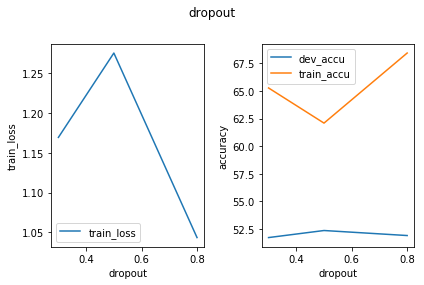

In [18]:
# experiment('dropout', [0.3, 0.5, 0.8])

In [ ]:
experiment('n_layers', [1, 2, 3])

Save log-emission probabilities using the best model saved

In [19]:
def get_log_emission(utt_to_frames_dict, features, prior, temp_parameter, best_model_path):
    """
    Save posteriors using the trained model
    """
    classifier_eval = torch.load(best_model_path)
    classifier_eval.eval()
    log_emission = []
    n_iter = 0
    for utt_idx in range(len(utt_to_frames_dict)):
        frame_id = utt_to_frames_dict[utt_idx]
        log_emission_utt = []
        for i in range(0, len(frame_id), batch_size):
            idx = frame_id[i:i+batch_size]
            Xs = torch.tensor(itemgetter(*idx)(features), dtype=torch.float32).to(device)
            log_pred_Ys = F.log_softmax(classifier_eval(Xs), dim=1).cpu().data.numpy()
            log_emission_utt.append(log_pred_Ys  - temp_parameter*np.log(prior))
        log_emission_utt = np.concatenate(log_emission_utt, axis=0)
        log_emission.append(log_emission_utt)

    return log_emission

In [20]:
def save_log_emission(temp_parameter=None):
    if temp_parameter is None:
        temp_parameter = out_cfg["temp_parameter"]
    print("Saving log emissions for temperature %.1f ...\n" % (temp_parameter))
    prior = data_ldr.get_prior()
    train_log_emission =  get_log_emission(train_utt_to_frames, train_features, prior, temp_parameter, save_model_fn)
    dev_log_emission = get_log_emission(dev_utt_to_frames, dev_features, prior, temp_parameter, save_model_fn)
    test_log_emission = get_log_emission(test_utt_to_frames, test_features, prior, temp_parameter, save_model_fn)
    log_emission_dict = {'Ytrain': train_log_emission, 'Ydev': dev_log_emission, 'Ytest': test_log_emission}
    np.savez_compressed(os.path.join('hybrid/data/log_emission/log_emission_'+str(temp_parameter)+'.npz'), **log_emission_dict)

In [21]:
save_log_emission() # 1.0
save_log_emission(temp_parameter=0.5)
save_log_emission(temp_parameter=0.0)

Saving log emissions for temperature 1.0 ...

Saving log emissions for temperature 0.5 ...

Saving log emissions for temperature 0.0 ...



## HMM inference using the posterior from neural network

In [22]:
def get_test_wer(model, posterior=None):
    test_wer = model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"], posterior)
    print("{:.2f}% TEST WER".format(test_wer * 100.))

In [23]:
data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)

with open("hybrid/hmm/models/multiple_digit_model.pkl", "rb") as f:
    full_model_trained = pkl.load(f)

log_emission_1 = np.load('hybrid/data/log_emission/log_emission_1.0.npz', allow_pickle=True)
log_emission_0 = np.load('hybrid/data/log_emission/log_emission_0.0.npz', allow_pickle=True)    

In [24]:
print('Baseline performance of the trained model')
get_test_wer(full_model_trained)

print('Performance of the trained model with normalized emission probabilities')
get_test_wer(full_model_trained, log_emission_1["Ytest"])

print('Performance of the trained model with unnormalized emission probabilities')
get_test_wer(full_model_trained, log_emission_0["Ytest"])

Baseline performance of the trained model
24.55% TEST WER
Performance of the trained model with normalized emission probabilities
20.91% TEST WER
Performance of the trained model with unnormalized emission probabilities
18.64% TEST WER


In [25]:
log_emission_05 = np.load('hybrid/data/log_emission/log_emission_0.5.npz', allow_pickle=True)
get_test_wer(full_model_trained, log_emission_05["Ytest"])

20.00% TEST WER
